In [1]:
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import os.path

import scipy,scipy.spatial
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100

from  data_utilities import *
# from definitions import *
# from run_train_eval_net import run_train_eval_net,run_eval_net

In [2]:
import os
GPU = "1"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]=GPU

In [3]:
dataset_name = 'ManyTx'
dataset_path='../ManyTx.pkl/'

compact_dataset = load_compact_pkl_dataset(dataset_path,dataset_name)

tx_list = compact_dataset['tx_list']
rx_list = compact_dataset['rx_list']

equalized = 0

capture_date_list = compact_dataset['capture_date_list']
n_tx = len(tx_list)
n_rx = len(rx_list)
print(n_tx,n_rx)

150 18


In [4]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K

In [5]:
 def create_net(ntx_i):

    inputs = Input(shape=(256,2))
    x = Reshape((256,2,1))(inputs)
    x = Conv2D(8,(3,2),activation='relu',padding = 'same')(x)
    x = MaxPool2D((2,1))(x)
    x = Conv2D(16,(3,2),activation='relu',padding = 'same')(x)
    x = MaxPool2D((2,1))(x)
    x = Conv2D(16,(3,2),activation='relu',padding = 'same')(x)
    x = MaxPool2D((2,2))(x)
    x = Conv2D(32,(3,1),activation='relu',padding = 'same')(x)
    x = MaxPool2D((2,1))(x)
    x = Conv2D(16,(3,1),activation='relu',padding = 'same')(x)
    #x = resnet(x,64,(3,2),'6')
    #x = MaxPool2D((2,2))(x)
    x = Flatten()(x)



    x = Dense(100, activation='relu', kernel_regularizer = keras.regularizers.l2(0.0001))(x)
    # x = Dropout(0.3)(x)
    x = Dense(80, activation='relu',kernel_regularizer = keras.regularizers.l2(0.0001))(x)
    x = Dropout(0.5)(x)
    x = Dense(ntx_i, activation='softmax',kernel_regularizer = keras.regularizers.l2(0.0001))(x)
    ops = x

    classifier = Model(inputs,ops)
    classifier.compile(loss='categorical_crossentropy',metrics=['categorical_accuracy'],optimizer=keras.optimizers.Adam(0.0005))
    
    return classifier

classifier = create_net(5)
classifier.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 256, 2, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 2, 8)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 2, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 2, 16)     │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 2, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 2, 16)      │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 1, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 1, 32)      │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 1, 16)      │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        25,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 80)             │         8,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,697 (155.07 KB)

 Trainable params: 39,697 (155.07 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
def evaluate_test(classifier):
    pred = classifier.predict(sig_dfTest)
    acc = np.mean(np.argmax(pred,1)==txidNum_dfTest)

    test_indx = ()
    for indx in range(len(tx_list)):
        cls_indx = np.where(txidNum_dfTest == indx)
        test_indx = test_indx + (cls_indx[0][:n_test_samples],)
    test_indx = np.concatenate(test_indx) 
    acc_bal = np.mean(np.argmax(pred[test_indx,:],1)==txidNum_dfTest[test_indx])
    return acc,acc_bal

In [7]:
TRAIN = True
continue_training = True
nreal = 5

real_list = list(range(nreal))

ntx_list = [10, 45, 80, 115,150]
print(ntx_list)

patience = 5
n_epochs = 100


smTest_results_real = []
dfTest_results_real = []
dfTestBal_results_real = []

for ntx_i in ntx_list:
    print("");print("")
    print("ntx_i: {}  ".format(ntx_i))
    fname_w = 'd006_{:04d}.weights.h5'.format(ntx_i)
    tx_train_list= tx_list[0:ntx_i]

    dataset = merge_compact_dataset(compact_dataset,capture_date_list,tx_train_list,rx_list, equalized=equalized)
    
    train_augset,val_augset,test_augset_smRx =  prepare_dataset(dataset,tx_train_list,
                                                        val_frac=0.1, test_frac=0.1)
    [sig_train,txidNum_train,txid_train,cls_weights] = train_augset
    [sig_valid,txidNum_valid,txid_valid,_] = val_augset
    [sig_smTest,txidNum_smTest,txid_smTest,cls_weights] = test_augset_smRx

    if continue_training:
        skip = os.path.isfile(fname_w)
    else:
        skip = False
    classifier = create_net(ntx_i)
    if TRAIN and not skip:
        filepath = f't_weights_{GPU}_{:04d}.keras'.format(ntx_i)
        c=[ keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True),
          keras.callbacks.EarlyStopping(monitor='val_loss',  patience=patience)]
        if isinstance(cls_weights, list):
            cls_weights = {i: w for i, w in enumerate(cls_weights)}
        history = classifier.fit(sig_train,txid_train,class_weight=cls_weights,
                                 validation_data=(sig_valid , txid_valid),callbacks=c, epochs=n_epochs)
        classifier.load_weights(filepath)
        classifier.save_weights(fname_w)
    else:
        classifier.load_weights(fname_w)

    smTest_r = classifier.evaluate(sig_smTest,txid_smTest,verbose=0)[1]


    print(smTest_r)
    smTest_results_real.append(smTest_r)
    K.clear_session()

[10, 45, 80, 115, 150]


ntx_i: 10  
Epoch 1/100
823/837 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.1123 - loss: 2.5785
Epoch 1: val_loss improved from inf to 2.13419, saving model to t_weights_1.keras
837/837 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - categorical_accuracy: 0.1127 - loss: 2.5777 - val_categorical_accuracy: 0.2009 - val_loss: 2.1342
Epoch 2/100
823/837 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.2039 - loss: 2.3317
Epoch 2: val_loss improved from 2.13419 to 1.93972, saving model to t_weights_1.keras
837/837 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - categorical_accuracy: 0.2042 - loss: 2.3308 - val_categorical_accuracy: 0.2837 - val_loss: 1.9397
Epoch 3/100
827/837 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.2664 - loss: 2.1458
Epoch 3: val_loss improved from 1.93972 to 1.84355, saving model to t_weights_1.keras
837/837 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - categorical_accuracy: 0.2666 - loss: 2.1454 - val_categorical_accuracy: 0.3226 - val_lo

[10, 45, 80, 115, 150]
[0.8134528994560242, 0.7085390686988831, 0.577674150466919, 0.5350282788276672, 0.444996178150177]


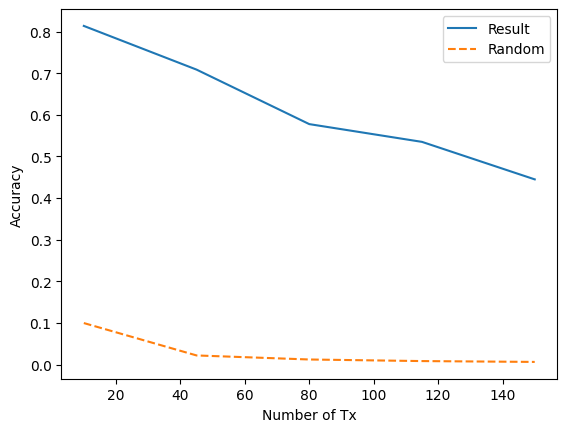

In [8]:
plt.plot(ntx_list,smTest_results_real)
plt.plot(ntx_list,1/np.array(ntx_list),'--')
plt.xlabel('Number of Tx')
plt.ylabel('Accuracy')
plt.legend(['Result','Random'])
print(ntx_list)
print(smTest_results_real)